# VGG-13 transformed to SNN and tested with cifar-10

This will be a tutorial of how to transform the VGG-13 model to an snn model using ml-genn. First, we need to import all the libraries that will be used.

In [6]:
import tensorflow as tf
import ml_genn as tg
from ml_genn import Model
from ml_genn.utils import raster_plot
import numpy as np
from six import iteritems
from time import perf_counter
import argparse
from ml_genn.layers import ConnectivityType
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import os
from ml_genn.converters import Simple
from ml_genn.converters import DataNorm
from ml_genn.converters import SpikeNorm
from ml_genn.converters import FewSpike
tf.random.set_seed(2345)
np.random.seed(2345)


#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#sess = tf.Session(config=config)

for gpu in tf.config.experimental.list_physical_devices('GPU'):
       tf.config.experimental.set_memory_growth(gpu, True)
#gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.6)
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [7]:
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


## Downloading and preprocessing dataset

We will be using the cifar 10 dataset. It consits of 50000 images (32,32,3) of 10 different classes.

In [8]:
data = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = data.load_data()

Image Classes:[6, 9, 9, 4, 1]
Image Labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


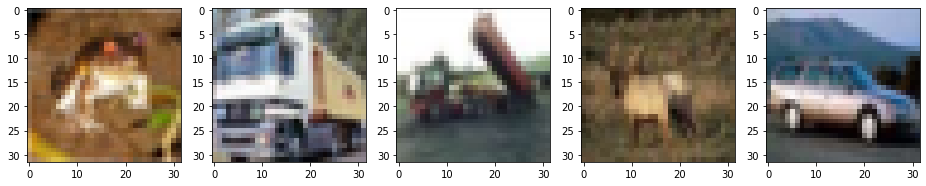

In [9]:
%matplotlib inline
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(16, 6)
for i in range(0,5):
    img = train_images[i]
    ax[i].imshow(img)
    fig.show()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Image Classes:' + str([x[0] for x in train_labels[0:5]]))
print('Image Labels: ' + str([classes[x[0]] for x in train_labels[0:5]]))


train_images = train_images / 255.0
test_images =  test_images / 255.0

# apparently the OneHotEncoder improves the measurements.... it did...
encoder = OneHotEncoder()
encoder.fit(train_labels)
train_labels = encoder.transform(train_labels).toarray()
test_labels = encoder.transform(test_labels).toarray()


x_norm, will be the dataset used in order to obtain the parameters needed to transform the VGG-13 into a SNN

In [10]:
x_norm = train_images[np.random.choice(train_images.shape[0], 256, replace=False)]

### Data augmentation
Here we define the data augmentation procedure that will be used for training the model

In [6]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                           width_shift_range=0.05,
                                                           height_shift_range=0.05,
                                                           rotation_range=20,
                                                           zoom_range=0.2,
                                                           shear_range=0.1)
data_gen.fit(train_images)

## Creating VGG-13 model

We created the vgg-13 model. An Image that deppicts the structure of the model can be found next. The path that deppicts the structure of vgg-13 is the B path. However, since we need to use these architecture weights to construct an SNN, the following constraints most be followed:


1.   The TF model most consist of ReLU layers
2.   No bias tensor most be included in the layers
3.   Average Pooling Layers most be used. This is because the concept of maximum output is less meaningful when the only values it can take are zero for n = 0 spikes, or one for n > 0 spikes.
4. The padding can only be of type valid or same

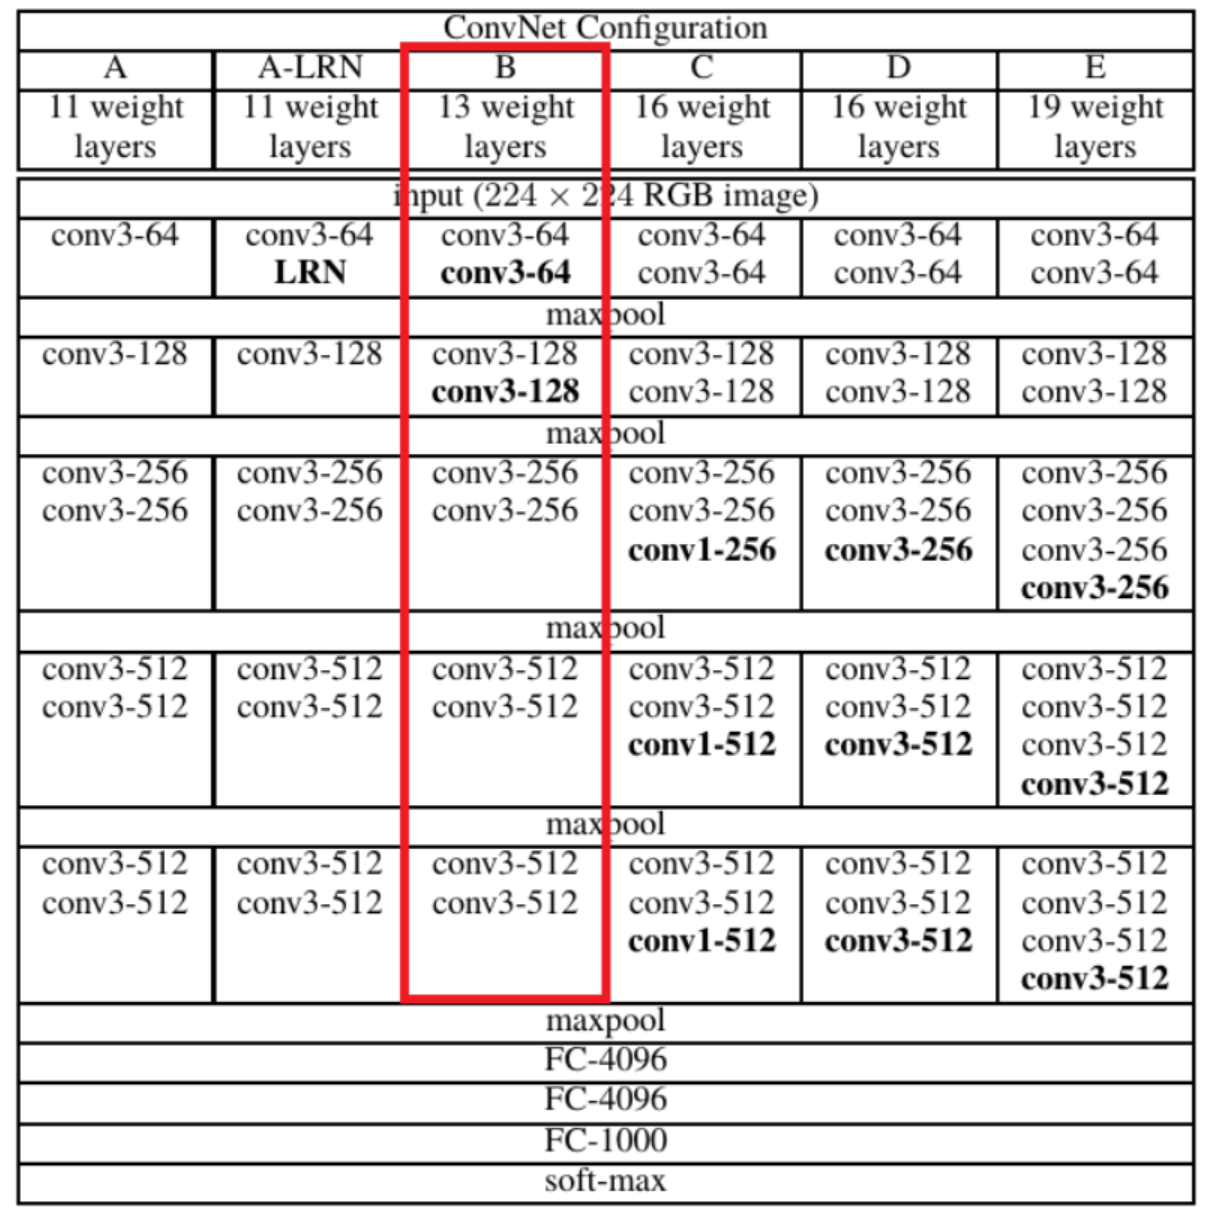


Image taken from https://arxiv.org/abs/1409.1556
    Authors: Karen Simonyan, Andrew Zisserman

In [7]:
# Create L2 regularizer
regularizer = tf.keras.regularizers.l2(0.00001) #0.0001
kernel_init = 'he_uniform'

vgg13_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False, input_shape=(32, 32, 3) ),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.AveragePooling2D((2,2), padding='same'),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.AveragePooling2D((2,2), padding='same'),
    
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.AveragePooling2D((2,2), padding='same'),

    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.AveragePooling2D((2,2), padding='same'),
    
    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.AveragePooling2D((2,2), padding='same'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(4096, activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=kernel_init, kernel_regularizer=regularizer, use_bias=False)
])

optimizer = tf.keras.optimizers.RMSprop(lr=0.00001, momentum=0.9)
vgg13_model.summary()
vgg13_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1728      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36864     
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73728     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147456    
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2

Epoch 77/200
195/195 [==============================] - 26s 134ms/step - loss: 0.6263 - accuracy: 0.9163 - val_loss: 0.7757 - val_accuracy: 0.8912
optimizer = tf.keras.optimizers.RMSprop(lr=0.00001, momentum=0.9)

## Training Model or Load Model

You have to train the model that you craeted in tensorflow as one normally does.

In [18]:
steps_per_epoch = train_labels.shape[0] // 128

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True,
                                                 monitor='val_accuracy')

history = vgg13_model.fit(data_gen.flow(train_images, train_labels, batch_size=128),
           validation_data=(test_images, test_labels), 
           epochs=2,
           steps_per_epoch=steps_per_epoch,
           batch_size=128,
           callbacks=[cp_callback])


checkpoint_path = "training_1/cp.ckpt"

# The model weights (that are considered the best) are loaded into the model.
vgg13_model.load_weights(checkpoint_path)

Epoch 1/200
390/390 [==============================] - 68s 85ms/step - loss: 2.5265 - accuracy: 0.1032 - val_loss: 2.4035 - val_accuracy: 0.1000

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to training_1/cp.ckpt
Epoch 2/200
390/390 [==============================] - 31s 80ms/step - loss: 2.3938 - accuracy: 0.1052 - val_loss: 2.2840 - val_accuracy: 0.1442

Epoch 00002: val_accuracy improved from 0.10000 to 0.14420, saving model to training_1/cp.ckpt
Epoch 3/200
390/390 [==============================] - 31s 80ms/step - loss: 2.1535 - accuracy: 0.1764 - val_loss: 1.7762 - val_accuracy: 0.3128

Epoch 00003: val_accuracy improved from 0.14420 to 0.31280, saving model to training_1/cp.ckpt
Epoch 4/200
390/390 [==============================] - 31s 80ms/step - loss: 1.8104 - accuracy: 0.3144 - val_loss: 1.6024 - val_accuracy: 0.4132

Epoch 00004: val_accuracy improved from 0.31280 to 0.41320, saving model to training_1/cp.ckpt
Epoch 5/200
390/390 [==================

In [10]:
LOAD_MODEL = True

if LOAD_MODEL:
    vgg13_model = tf.keras.models.load_model('vgg13_tf_model')

else:
    steps_per_epoch = train_labels.shape[0] // 128

    checkpoint_path = "training_1/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1,
                                                     save_best_only=True,
                                                     monitor='val_accuracy')

    history = vgg13_model.fit(data_gen.flow(train_images, train_labels, batch_size=128),
               validation_data=(test_images, test_labels), 
               epochs=2,
               steps_per_epoch=steps_per_epoch,
               batch_size=128,
               callbacks=[cp_callback])


    checkpoint_path = "training_1/cp.ckpt"

    # The model weights (that are considered the best) are loaded into the model.
    vgg13_model.load_weights(checkpoint_path)

The current model that we worked in got an validation accuracy of 89.5% as shown below

In [8]:
tf_eval_start_time = perf_counter()
vgg13_model.evaluate(test_images, test_labels)
print("TF evaluation:%f" % (perf_counter() - tf_eval_start_time))

313/313 [==============================] - 4s 6ms/step - loss: 0.6839 - accuracy: 0.8957
TF evaluation:3.945834


## Transform the model to an SNN

Here are the parameters that can be used for the rate based conversion:

Here are the normalization methods that most be used:


## Encoding technique used for input data transformation

The input data of an SNN most be encoded in order for it to be fed to an SNN. This allows the networks to have pseudo-simultaneity of input and output, time-varying inputs can be more efficiently processed and more efficient computation can be obtained. These are the techniques that you may use for encoding your input data:

- Spike input neurons : 'spike'
- Spike input neurons signed : 'spike_signed'
- Poisson input neurons : 'poisson'
- Poisson input neurons signed : 'poisson_signed'
- Integrate and fire input : 'if'

The next image defines an integrate and fire neuron, this was obtained from Fast-Classifying, High-Accuracy Spiking Deep
Networks Through Weight and Threshold paper by Diehl, etc al. 
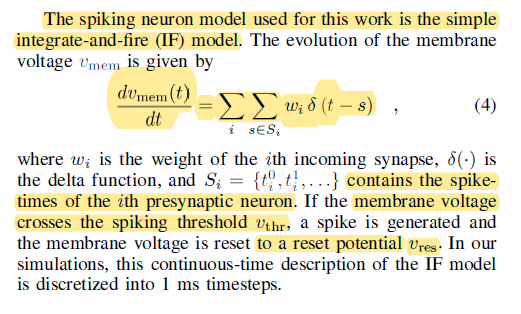


## Weight normalization methods

In order to obtain near-lossless accuracy and faster convergence, a weight normalization method most be applied for the conversion of the ANN. This is because these techniques ensure that the activations of the networks are sufficiently small to prevent the ReLU from overestimating output activations. The x_norm parameter in each of the classes is the sample data that will be used for making the transformation.

### Data Normalization

In this technique, some of the training set is used to estimate typical activations within the network. The training set is propagated through the network and the ReLU activations are stored. The weights are then normalized according to the maximum possible activation within the training set, so that this case only emits a single spike. This normalization also takes into account the maximum single input weight as well. The algorithm (taken from Fast-Classifying, High-Accuracy Spiking Deep
Networks Through Weight and Threshold paper by Diehl, etc al.) can be seen next:

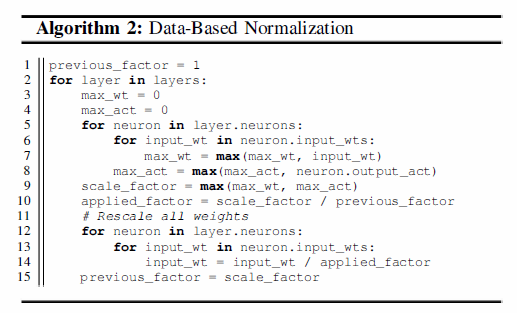

- Data Normalization : DataNorm(norm_data=[norm_data], input_type=)

### Spike Normalization

This weight normalization technique balances the threshold of each layer by considering the actual operation of the SNN in the loop during the ANN-SNN conversion process. To minimize the temporal delay of the neuron and ensure that the neuron firing threshold is not too low, here we weight-normalize the first layer depending on the maximum spike-based input received by the first layer. After the threshold of the first layer is set, a representative spike train at the output of the first layer is provided that enables the generation of the input spike-stream for the next layer. This is used to calculate the next threshold. This is all based on the article Going Deeper in Spiking Neural Networks: VGG and Residual Architectures by Sengupta, et al. A diagram that represent the pseudo code is now presented:

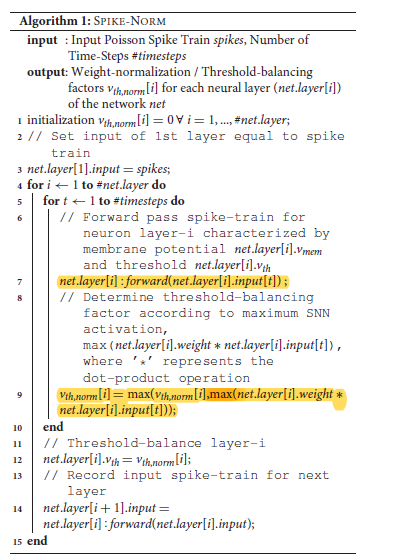

- Spike Normalization  : SpikeNorm(norm_data=[norm_data], norm_time=norm_time, input_type=self.input_type)

### Few Spikes

- FS : FewSpike(K=K, norm_data=[norm_data])


### Simple

- Simple : Simple(input_type=)



In [13]:
converter_type = 'fs'
norm_time = 10 if (converter_type == 'fs') else 2500
if (converter_type == 'fs'):
    converter  = FewSpike(K=norm_time, norm_data=[x_norm])
elif (converter_type == 'dn'):
    converter = DataNorm(norm_data=[x_norm], input_type='poisson')
elif (converter_type == 'sn'):
    converter = SpikeNorm(norm_data=[x_norm], norm_time=norm_time, input_type='poisson')
elif not converter:
    converter = Simple(input_type='poisson')

Then, we create the ML model GeNN model based on the Tensorflow model. The function is called convert_tf_model. It has the following parameters:

- tf_model : this is the tensorflow model that you wish to convert.

- converter : the converter that we previously defined to trasform

- connectivity_type : 'procedural' or 'sparse'

- dt : 

- batch_size : the batch size for doing the Data Normalization

- rng_seed : A seed

- kernel_profiling : True


Compile_kwargs -- additional arguments to pass trhough to the model.

In [11]:
# Convert and compile ML GeNN model
mlg_model = Model.convert_tf_model(
    vgg13_model, converter=converter, connectivity_type='procedural',
    dt=1.0, batch_size=1, rng_seed=0, 
    kernel_profiling=True)

converting Conv2D layer <conv2d>
converting Conv2D layer <conv2d_1>
deferring AveragePooling2D layer <average_pooling2d>
converting AveragePooling2D -> Conv2D layers <conv2d_2>
converting Conv2D layer <conv2d_3>
deferring AveragePooling2D layer <average_pooling2d_1>
converting AveragePooling2D -> Conv2D layers <conv2d_4>
converting Conv2D layer <conv2d_5>
deferring AveragePooling2D layer <average_pooling2d_2>
converting AveragePooling2D -> Conv2D layers <conv2d_6>
converting Conv2D layer <conv2d_7>
deferring AveragePooling2D layer <average_pooling2d_3>
converting AveragePooling2D -> Conv2D layers <conv2d_8>
converting Conv2D layer <conv2d_9>
ignoring Dropout layer <dropout>
deferring AveragePooling2D layer <average_pooling2d_4>
ignoring Flatten layer <flatten>
converting AveragePooling2D -> Dense layers <dense>
ignoring Dropout layer <dropout_1>
converting Dense layer <dense_1>
ignoring Dropout layer <dropout_2>
converting Dense layer <dense_2>
layer <conv2d> threshold: 2.1134672164916

Then, we evaluate the performance of the SNN model by trying it on the validation data.

In [12]:
time = 2500 #  --  sample presentation time (msec)
mlg_eval_start_time = perf_counter()
acc, spk_i, spk_t = mlg_model.evaluate([test_images], [test_labels], time, save_samples=[])
print("MLG evaluation:%f" % (perf_counter() - mlg_eval_start_time))

100%|██████████| 10000/10000 [2:10:41<00:00,  1.28it/s, accuracy: 65.66] 

MLG evaluation:7841.515505


In [13]:
print('Accuracy of VGG16 GeNN model: {}%'.format(acc[0]))

Accuracy of VGG16 GeNN model: 65.66%


## Few Spikes based transformation

In [11]:
converter = FewSpike(K=10, signed_input=True, norm_data=[x_norm])

In [12]:
# Convert and compile ML GeNN model
mlg_model = Model.convert_tf_model(
    vgg13_model, converter=converter, connectivity_type='procedural',
    dt=1.0, batch_size=1, rng_seed=0, 
    kernel_profiling=True)

converting Conv2D layer <conv2d>
converting Conv2D layer <conv2d_1>
deferring AveragePooling2D layer <average_pooling2d>
converting AveragePooling2D -> Conv2D layers <conv2d_2>
converting Conv2D layer <conv2d_3>
deferring AveragePooling2D layer <average_pooling2d_1>
converting AveragePooling2D -> Conv2D layers <conv2d_4>
converting Conv2D layer <conv2d_5>
deferring AveragePooling2D layer <average_pooling2d_2>
converting AveragePooling2D -> Conv2D layers <conv2d_6>
converting Conv2D layer <conv2d_7>
deferring AveragePooling2D layer <average_pooling2d_3>
converting AveragePooling2D -> Conv2D layers <conv2d_8>
converting Conv2D layer <conv2d_9>
ignoring Dropout layer <dropout>
deferring AveragePooling2D layer <average_pooling2d_4>
ignoring Flatten layer <flatten>
converting AveragePooling2D -> Dense layers <dense>
ignoring Dropout layer <dropout_1>
converting Dense layer <dense_1>
ignoring Dropout layer <dropout_2>
converting Dense layer <dense_2>


In [13]:
time = 10 #  --  sample presentation time (msec)
mlg_eval_start_time = perf_counter()
acc, spk_i, spk_t = mlg_model.evaluate([test_images], [test_labels], time, save_samples=[])
print("MLG evaluation:%f" % (perf_counter() - mlg_eval_start_time))

100%|██████████| 10000/10000 [01:32<00:00, 108.34it/s, accuracy: 98.71]

MLG evaluation:92.307003


In [14]:
print('Accuracy of VGG16 GeNN model: {}%'.format(acc[0]))

Accuracy of VGG16 GeNN model: 98.71%
